# **Modelo GRU keras-tuner - Séries Temporais**

###  Notebook: `03_08_C2_GRU(keras-tuner)`

## Modelo GRU para predição

---


___

In [37]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import math
import requests
import json
import os
import statsmodels.api as sm
import tensorflow as tf
from pandas import concat
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import math

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import keras_tuner as kt
from tensorflow.keras import initializers
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [38]:
pd.options.display.float_format = '{:,.2f}'.format

# Ajustar parâmetros de plotagem

plt.rcParams["text.color"] = 'Black'
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["figure.figsize"] = [15, 6]
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams['grid.alpha'] = 0.90
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['lines.markersize'] = 8.0

## 1. Importando os datasets

In [39]:
dataset_cluster2_series = pd.read_csv("datasets//dataset_cluster2_series.csv", header=0, index_col=0)
dataset_cluster2_validacao = pd.read_csv("datasets//dataset_cluster2_validation.csv", header=0, index_col=0)

dataset_cluster2_series = dataset_cluster2_series.append(dataset_cluster2_validacao)

In [40]:
dataset_cluster2_series.head()

,indice_pimpf,ipca,taxa_selic,taxa_cambio,ibcbr,tjlp,pib_mensal,preco_brent,desembolso,debitos,arrecadacao
mes,,,,,,,,,,,
2004-01-01 00:00:00,104.00,0.76,16.32,136.19,98.59,10.00,"1,735,331.50",31.18,"1,107.00","730,970,151.84","6,709,728,197.38"
2004-02-01 00:00:00,103.10,0.61,16.30,139.84,99.45,10.00,"1,746,819.20",30.87,"2,559.00","4,150,874,441.76","5,844,143,844.18"
2004-03-01 00:00:00,113.00,0.47,16.19,138.89,111.98,10.00,"1,765,492.20",33.80,"4,302.00","3,778,614,348.15","5,757,594,052.26"
2004-04-01 00:00:00,107.80,0.37,15.96,138.85,107.36,9.75,"1,781,058.00",33.36,"5,474.00","4,927,327,281.54","7,872,112,724.87"
2004-05-01 00:00:00,108.90,0.51,15.77,148.25,106.03,9.75,"1,800,951.10",37.92,"5,976.00","2,175,495,525.08","7,156,122,486.18"


## 2. Preparando o dataset para a rede neural GRU

In [41]:
np.random.seed(10)


In [42]:
serie_cluster2 = np.array(dataset_cluster2_series)

In [43]:
print(serie_cluster2)

[[1.04000000e+02 7.60000000e-01 1.63200000e+01 ... 1.10700000e+03
  7.30970152e+08 6.70972820e+09]
 [1.03100000e+02 6.10000000e-01 1.63000000e+01 ... 2.55900000e+03
  4.15087444e+09 5.84414384e+09]
 [1.13000000e+02 4.70000000e-01 1.61900000e+01 ... 4.30200000e+03
  3.77861435e+09 5.75759405e+09]
 ...
 [1.01200000e+02 8.60000000e-01 1.90000000e+00 ... 8.31900000e+03
  2.68586194e+10 3.26409023e+10]
 [1.04100000e+02 8.90000000e-01 1.90000000e+00 ... 9.33800000e+03
  2.20785725e+10 2.66353020e+10]
 [1.10200000e+02 1.35000000e+00 1.90000000e+00 ... 1.26730000e+04
  1.85607303e+10 2.91025891e+10]]


### 2.1 Convertendo o array em um modelo de dados 3D para entrada na rede GRU

---
Créditos: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

Para fazer a predição, utilizei os 12 primeiros meses para predizer o seguinte. Com isso, o dataset perde 12 meses, uma vez que os 11 primeiros meses não possuem 12 meses anteriores e o último mês não possui valor conhecido da arrecadação do mês subsequente.

___

In [44]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
 
raw = DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
# values = raw.values
values = pd.DataFrame(serie_cluster2).values
serie_cluster2_prepared = series_to_supervised(values,12)
print(serie_cluster2_prepared)

     var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12       104.00        0.76       16.32      136.19       98.59       10.00   
13       103.10        0.61       16.30      139.84       99.45       10.00   
14       113.00        0.47       16.19      138.89      111.98       10.00   
15       107.80        0.37       15.96      138.85      107.36        9.75   
16       108.90        0.51       15.77      148.25      106.03        9.75   
..          ...         ...         ...         ...         ...         ...   
199       97.90        0.11        5.90      114.23      141.78        5.95   
200      101.70       -0.04        5.71      117.25      138.26        5.95   
201      102.50        0.10        5.38      116.42      142.80        5.57   
202       99.40        0.51        4.90      117.74      138.83        5.57   
203      100.60        1.15        4.59      114.94      137.50        5.57   

      var7(t-12)  var8(t-12)  var9(t-12)       var1

In [45]:
serie_cluster2_prepared.head(20)

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var6(t-12),var7(t-12),var8(t-12),var9(t-12),var10(t-12),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
12,104.00,0.76,16.32,136.19,98.59,10.00,"1,735,331.50",31.18,"1,107.00","730,970,151.84",...,0.58,17.93,123.29,103.52,9.75,"1,976,732.70",44.28,"2,089.00","2,991,476,281.61","9,171,568,873.85"
13,103.10,0.61,16.30,139.84,99.45,10.00,"1,746,819.20",30.87,"2,559.00","4,150,874,441.76",...,0.59,18.47,118.92,104.00,9.75,"1,994,573.00",45.56,"3,051.00","1,883,603,437.97","6,970,913,797.98"
14,113.00,0.47,16.19,138.89,111.98,10.00,"1,765,492.20",33.80,"4,302.00","3,778,614,348.15",...,0.61,18.97,124.02,115.42,9.75,"2,012,678.10",53.08,"4,797.00","2,541,728,506.27","7,356,127,741.47"
15,107.80,0.37,15.96,138.85,107.36,9.75,"1,781,058.00",33.36,"5,474.00","4,927,327,281.54",...,0.87,19.32,118.03,112.35,9.75,"2,032,903.20",51.86,"5,966.00","2,865,775,194.99","9,611,372,227.63"
16,108.90,0.51,15.77,148.25,106.03,9.75,"1,800,951.10",37.92,"5,976.00","2,175,495,525.08",...,0.49,19.61,111.59,110.86,9.75,"2,050,901.00",48.67,"7,363.00","2,254,299,807.52","7,820,800,673.18"
17,113.10,0.71,15.80,149.04,107.00,9.75,"1,828,299.90",35.19,"7,338.00","2,078,371,021.40",...,-0.02,19.75,109.88,111.50,9.75,"2,066,440.60",54.31,"10,274.00","2,480,066,385.61","7,480,433,753.36"
18,110.90,0.91,15.77,143.11,111.47,9.75,"1,853,700.20",38.37,"8,251.00","2,531,326,742.62",...,0.25,19.72,108.29,113.15,9.75,"2,079,143.40",57.58,"11,523.00","3,324,322,708.25","8,976,327,089.48"
19,113.20,0.69,15.86,140.62,110.65,9.75,"1,878,059.70",43.03,"8,887.00","1,900,320,314.96",...,0.17,19.75,108.07,115.15,9.75,"2,097,211.10",64.09,"13,512.00","2,183,455,425.52","7,829,659,673.51"
20,107.60,0.33,16.09,135.23,109.21,9.75,"1,894,202.40",43.38,"9,562.00","2,038,177,171.23",...,0.35,19.61,105.95,110.95,9.75,"2,114,047.40",62.98,"14,681.00","2,431,266,772.14","8,007,888,650.95"
21,103.80,0.44,16.41,133.55,108.89,9.75,"1,909,813.00",49.82,"11,099.00","2,499,240,580.37",...,0.75,19.25,103.63,111.33,9.75,"2,132,693.90",58.52,"15,620.00","2,936,053,274.59","10,555,158,444.11"


### 2.3 Dividindo o dataset em sets de treino, teste e predição

In [46]:
# Divide em conjuntos de treino e teste e predição
values = serie_cluster2_prepared.values
# Base de treino com 144 meses
periodo_treino = 144
train = values[:periodo_treino, :]
test = values[periodo_treino:180, :]
predict = values[180:, :]

In [47]:
# Divide em entradas e saídas
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
predict_X, predict_y = predict[:, :-1], predict[:, -1]



### Normalizando os datasets

In [48]:
## Normalizando os datasets

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_predict_X = MinMaxScaler(feature_range=(0, 1))
scaler_predict_y = MinMaxScaler(feature_range=(0, 1))


train_X = scaler_X.fit_transform(train_X)
test_X = scaler_X.fit_transform(test_X)

train_y = scaler_y.fit_transform(train_y.reshape(-1,1))
test_y = scaler_y.fit_transform(test_y.reshape(-1,1))

predict_X = scaler_predict_X.fit_transform(predict_X)
predict_y = scaler_predict_y.fit_transform(predict_y.reshape(-1,1))

In [49]:
# Reformata o array 3D 
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
predict_X = predict_X.reshape((predict_X.shape[0], 1, predict_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,predict_X.shape, predict_y.shape)

(144, 1, 142) (144, 1) (36, 1, 142) (36, 1) (12, 1, 142) (12, 1)


## 3. Implementando o modelo GRU


In [50]:
#Função para calculo do MAPE - Mean Absolute Percentage Error, que será  utilizado como medida de erro do modelo

def calculo_mape(y_pred,y_true):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
train_X.shape

(144, 1, 142)

In [52]:
def model_builder(hp):
    
    
    model = keras.Sequential()
    
    # Define o número de perceptrons da camada inicial
    # Choose an optimal value between 1-100
    
    hp_units = hp.Int('units', min_value=1, max_value=100, step=1)
    model.add(keras.layers.GRU(units=hp_units, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
     
    model.add(keras.layers.Dense(1))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_error',
                metrics=[keras.metrics.MeanSquaredError()])

    return model

In [53]:
tuner = kt.Hyperband(model_builder,
                    objective= 'val_loss',
                    max_epochs=50,
                    factor=2,
                    directory='hypertuner',
                    project_name='gru_keras1')

INFO:tensorflow:Reloading Oracle from existing project hypertuner\gru_keras1\oracle.json
INFO:tensorflow:Reloading Tuner from hypertuner\gru_keras1\tuner0.json


In [54]:
# Reexecutar se necessário. Projeto lstm_keras_1 disponível no repositório

tuner.search(train_X, train_y, epochs=50, validation_data=(test_X, test_y))
best_hps = tuner.get_best_hyperparameters()[0]


INFO:tensorflow:Oracle triggered exit


In [55]:
print(f"""
A busca de hiperparâmentro foi finalizada. O número ótimo de perceptrons na camada LSTM é
{best_hps.get('units')} e a melhor taxa de aprendizado do otimizador é {best_hps.get('learning_rate')}.
""")
# 


A busca de hiperparâmentro foi finalizada. O número ótimo de perceptrons na camada LSTM é
79 e a melhor taxa de aprendizado do otimizador é 0.001.



In [56]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_X, train_y, epochs=50, batch_size=32, 
                    validation_data=(test_X, test_y),  verbose=2, shuffle=False)


Epoch 1/50
5/5 - 2s - loss: 0.1925 - mean_squared_error: 0.1925 - val_loss: 0.1253 - val_mean_squared_error: 0.1253
Epoch 2/50
5/5 - 0s - loss: 0.1233 - mean_squared_error: 0.1233 - val_loss: 0.0983 - val_mean_squared_error: 0.0983
Epoch 3/50
5/5 - 0s - loss: 0.0516 - mean_squared_error: 0.0516 - val_loss: 0.1058 - val_mean_squared_error: 0.1058
Epoch 4/50
5/5 - 0s - loss: 0.0470 - mean_squared_error: 0.0470 - val_loss: 0.1143 - val_mean_squared_error: 0.1143
Epoch 5/50
5/5 - 0s - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 6/50
5/5 - 0s - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0472 - val_mean_squared_error: 0.0472
Epoch 7/50
5/5 - 0s - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0590 - val_mean_squared_error: 0.0590
Epoch 8/50
5/5 - 0s - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0654 - val_mean_squared_error: 0.0654
Epoch 9/50
5/5 - 0s - loss: 0.0188 - mean_squared_error: 0.0188 - val_lo

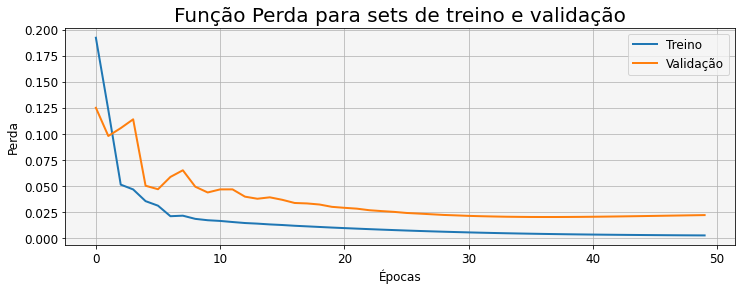

In [57]:
# Perda nos sets de treino e validação

plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Função Perda para sets de treino e validação')
plt.grid(True)
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()


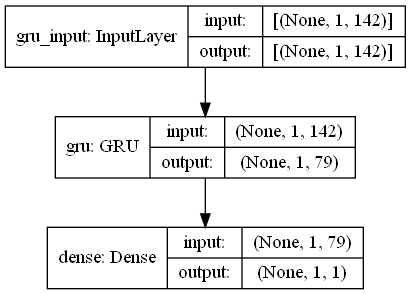

In [58]:

plot_model(model, show_shapes=True)

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 79)             52851     
_________________________________________________________________
dense (Dense)                (None, 1, 1)              80        
Total params: 52,931
Trainable params: 52,931
Non-trainable params: 0
_________________________________________________________________


# 4. Fazendo a validação para o período de 2017 a 2019

In [73]:
# Realizando a predição


yhat = model.predict(test_X)
test_X_final = test_X.reshape(test_X.shape[0], test_X.shape[2])

# invertendo a normalização para apresentar a previsão

yhat_reshaped = yhat.reshape(len(yhat),1)
inv_yhat = np.concatenate((yhat_reshaped, test_X_final[:, :-1]), axis=1)

inv_yhat = inv_yhat[:,0]

test_y_final = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_final, test_X_final[:, 1:]), axis=1)

inv_y = inv_y[:,0]


# Calculando RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))


print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.150


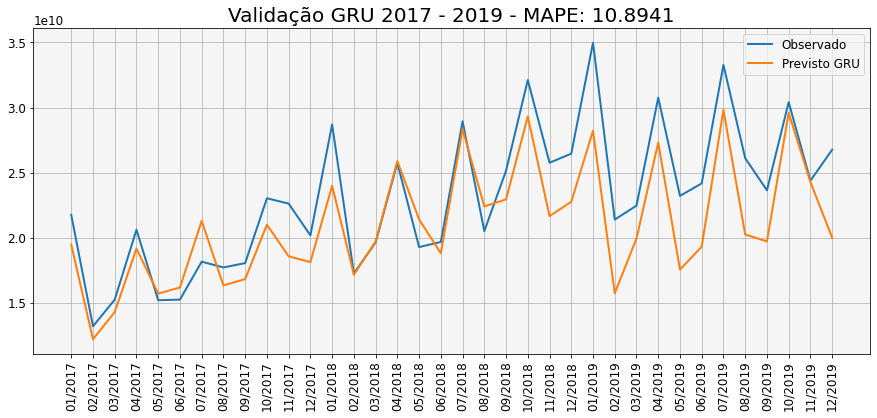

In [74]:
test_y_inv = scaler_y.inverse_transform(test_y_final)
yhat_final_inv = scaler_y.inverse_transform(yhat_reshaped)

df_data = pd.date_range('2017-01','2020-01', freq = 'm')

# Plota o valor observado vs previsto. 

plt.figure(figsize=(15,6))
plt.plot(test_y_inv, label='Observado')
plt.plot(yhat_final_inv, label='Previsto GRU')
plt.legend()
plt.title('Validação GRU 2017 - 2019 - MAPE: %.4f' % calculo_mape(yhat_final_inv, test_y_inv))
plt.xticks(np.arange(len(test_y_inv)),df_data.strftime('%m/%Y'), rotation='vertical')
plt.grid(True)
plt.show()

In [75]:
variacao_percentual = pd.DataFrame(((test_y_inv/yhat_final_inv)-1) ,columns=['variacao'])

In [76]:
set_alerta_negativo = pd.DataFrame()
set_normal= pd.DataFrame()
set_alerta_positivo = pd.DataFrame()

In [77]:
for i in range (len(variacao_percentual)):
    if variacao_percentual.iloc[i].values[0] > 0.05:
        set_alerta_positivo = set_alerta_positivo.append(variacao_percentual[i:i+1])
    elif variacao_percentual.iloc[i].values[0] < -0.05:
        set_alerta_negativo = set_alerta_negativo.append(variacao_percentual[i:i+1])
    else:
        set_normal = set_normal.append(variacao_percentual[i:i+1])

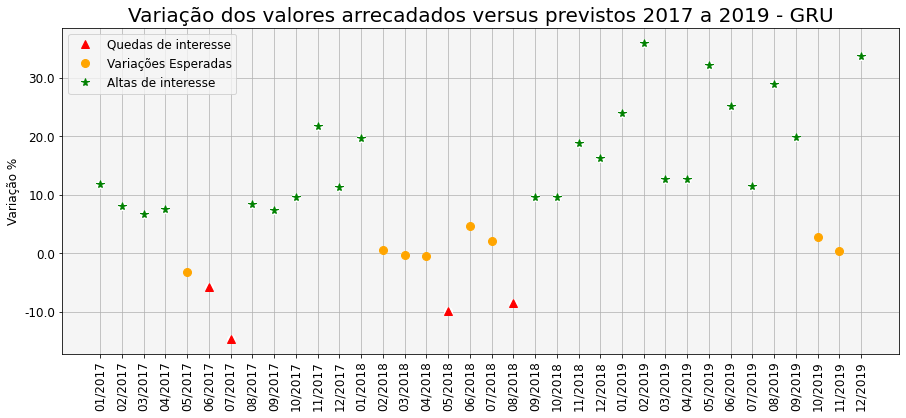

In [78]:
df_data = pd.date_range('2017-01','2020-01', freq = 'm')

#Plota o resultado do modelo
fig, ax = plt.subplots(figsize=(15,6))
ax.set_ylabel('Variação %')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))



plt.plot(variacao_percentual * 100, 'o', color='white')


if len(set_alerta_negativo) > 0:
    plt.plot(set_alerta_negativo * 100, 'g^', 
             color='red',  label='Quedas de interesse')

if len(set_normal) > 0:
    plt.plot(set_normal * 100, 'o', color='orange',  label='Variações Esperadas')

if len(set_alerta_positivo) > 0:
    plt.plot(set_alerta_positivo * 100, '*', color='green',  label='Altas de interesse')
    
    
plt.title('Variação dos valores arrecadados versus previstos 2017 a 2019 - GRU' )
plt.grid(True)
ax.set_xticks(range(0,36))
plt.xticks(ax.get_xticks(), df_data.strftime('%m/%Y'), rotation='vertical')
plt.legend(loc='upper left')

# 5. Predição para 2020

In [79]:
# Realizando a predição


yhat = model.predict(predict_X)
predict_X_final = predict_X.reshape(predict_X.shape[0], predict_X.shape[2])

# Invertendo a escala para apresentar a previsão

yhat_reshaped = yhat.reshape(len(yhat),1)
inv_yhat = np.concatenate((yhat_reshaped, predict_X_final[:, :-1]), axis=1)

inv_yhat = inv_yhat[:,0]
predict_y_final = predict_y.reshape((len(predict_y), 1))
inv_y = np.concatenate((predict_y_final, predict_X_final[:, 1:]), axis=1)

inv_y = inv_y[:,0]

# Calculando o RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))

print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.241


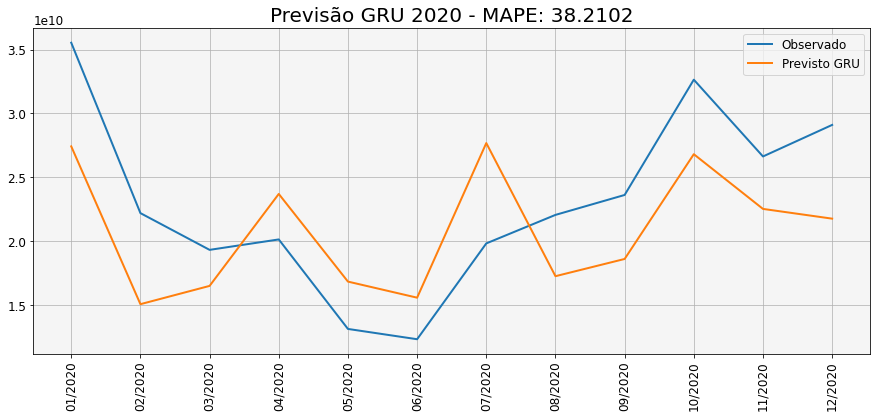

In [80]:
predict_y_inv = scaler_predict_y.inverse_transform(predict_y_final)
yhat_final_inv = scaler_predict_y.inverse_transform(yhat_reshaped)

df_data = pd.date_range('2020-01','2021-01', freq = 'm')

# Plota o valor observado vs previsto. 

plt.figure(figsize=(15,6))
plt.plot(predict_y_inv, label='Observado')
plt.plot(yhat_final_inv, label='Previsto GRU')
plt.legend()
plt.title('Previsão GRU 2020 - MAPE: %.4f' % calculo_mape(yhat_final_inv[0], predict_y_inv))
plt.xticks(np.arange(len(predict_y_inv)),df_data.strftime('%m/%Y'), rotation='vertical')
plt.grid(True)
plt.show()

In [81]:
variacao_percentual = pd.DataFrame(((predict_y_inv/yhat_final_inv)-1) ,columns=['variacao'])

In [82]:
set_alerta_negativo = pd.DataFrame()
set_normal= pd.DataFrame()
set_alerta_positivo = pd.DataFrame()

In [83]:
for i in range (len(variacao_percentual)):
    if variacao_percentual.iloc[i].values[0] > 0.05:
        set_alerta_positivo = set_alerta_positivo.append(variacao_percentual[i:i+1])
    elif variacao_percentual.iloc[i].values[0] < -0.05:
        set_alerta_negativo = set_alerta_negativo.append(variacao_percentual[i:i+1])
    else:
        set_normal = set_normal.append(variacao_percentual[i:i+1])
        

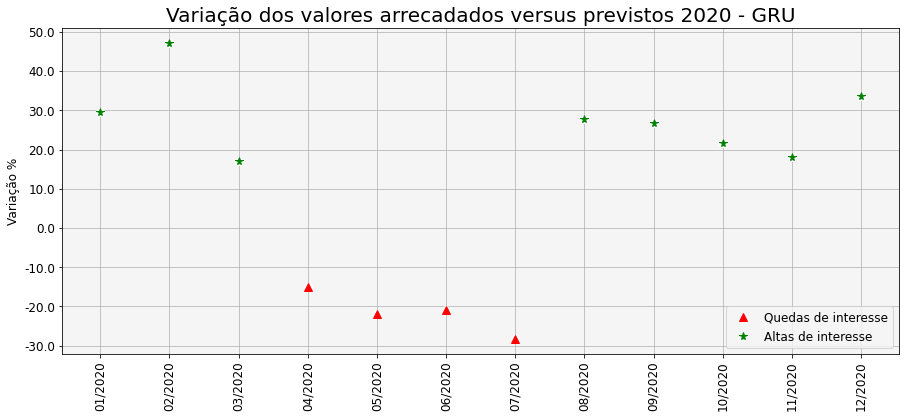

In [84]:


df_data = pd.date_range('2020-01','2021-01', freq = 'm')

#Plota o resultado do modelo
fig, ax = plt.subplots(figsize=(15,6))
ax.set_ylabel('Variação %')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

plt.plot(variacao_percentual * 100, 'o', color='white')

if len(set_alerta_negativo) > 0:
    plt.plot(set_alerta_negativo * 100, 'g^', 
             color='red',  label='Quedas de interesse')

if len(set_normal) > 0:
    plt.plot(set_normal * 100, 'o', color='orange',  label='Variações Esperadas')

if len(set_alerta_positivo) > 0:
    plt.plot(set_alerta_positivo * 100, '*', color='green',  label='Altas de interesse')
    
plt.title('Variação dos valores arrecadados versus previstos 2020 - GRU' )
plt.grid(True)
ax.set_xticks(range(0,12))
plt.xticks(ax.get_xticks(), df_data.strftime('%m/%Y'), rotation='vertical')
plt.legend(loc='lower right')